Training samples: 46667, Testing samples: 23333
MNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)
Epoch [1/30], Loss: 0.3117
Epoch [2/30], Loss: 0.1100
Epoch [3/30], Loss: 0.0799
Epoch [4/30], Loss: 0.0691
Epoch [5/30], Loss: 0.0572
Epoch [6/30], Loss: 0.0494
Epoch [7/30], Loss: 0.0445
Epoch [8/30], Loss: 0.0397
Epoch [9/30], Loss: 0.0363
Epoch [10/30], Loss: 0.0336
Epoch [11/30], Loss: 0.0259
Epoch [12/30], Loss: 0.0266
Epoch [13/30], Loss: 0.0270
Epoch [14/30], Loss: 0.0232
Epoch [15/30], Loss: 0.0202
Epoch [16/30], Loss: 0.0161
Epoch [17/30]

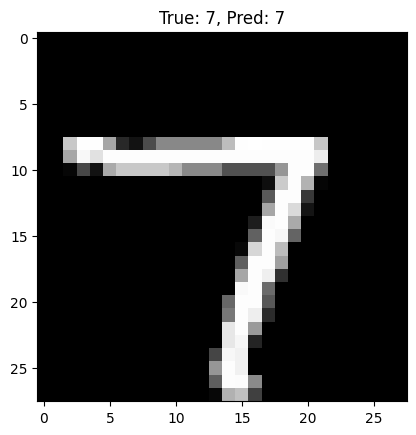

Sample 2: True Label: 0, Predicted: 0


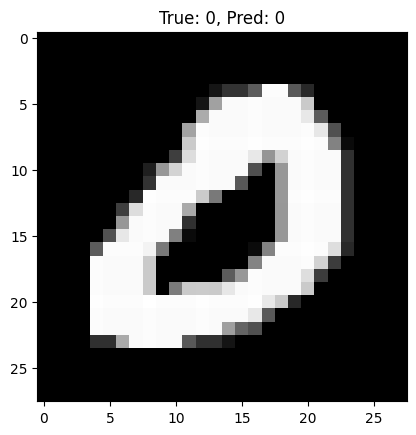

Sample 3: True Label: 2, Predicted: 2


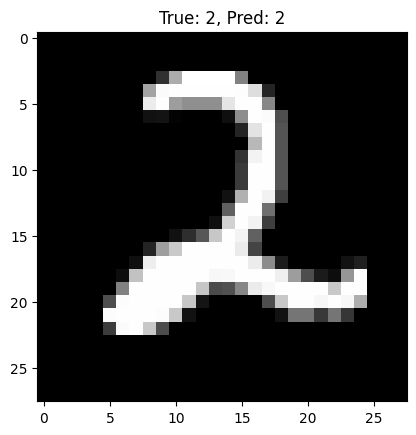

Sample 4: True Label: 3, Predicted: 3


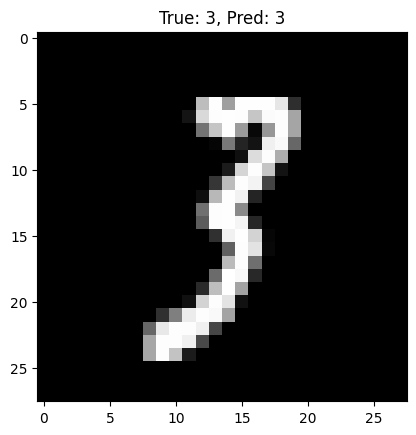

Sample 5: True Label: 5, Predicted: 5


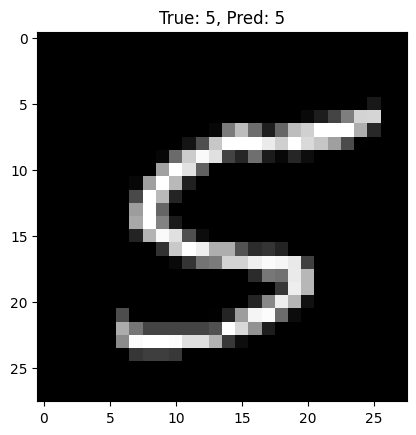

ONNX model saved to mnist_cnn.onnx
ONNX model prediction: 2
True label: 2


C:\Users\nafiu\AppData\Local\Temp\ipykernel_9788\2251493136.py:50: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if infer:


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, ConcatDataset
import matplotlib.pyplot as plt
import random
import numpy as np
import torch.onnx
import onnxruntime as ort

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

full_dataset = ConcatDataset([train_dataset, test_dataset])
total_samples = len(full_dataset)
test_size = total_samples // 3
train_size = total_samples - test_size

train_data, test_data = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
print(f"Training samples: {len(train_data)}, Testing samples: {len(test_data)}")

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class MNISTCNN(nn.Module):
    def __init__(self):
        super(MNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3) 
        self.pool1 = nn.MaxPool2d(kernel_size=2) 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) 
        self.pool2 = nn.MaxPool2d(kernel_size=2)  
        self.fc1   = nn.Linear(64 * 5 * 5, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2   = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1) 

    def forward(self, x, infer=False):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        if infer:
            x = self.softmax(x)
        return x

model = MNISTCNN()
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def lr_lambda(epoch):
    return 0.9 if (epoch > 0 and epoch % 5 == 0) else 1.0

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


num_epochs = 30
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    scheduler.step() 
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

model.eval()
test_images = []
test_labels = []

for img, label in test_data:
    test_images.append(img.numpy())
    test_labels.append(label)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

indices = random.sample(range(len(test_images)), 5)
selected_images = torch.tensor(test_images[indices]).to(device)
selected_labels = test_labels[indices]

with torch.no_grad():
    outputs = model(selected_images)
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()

for i, pred in enumerate(predictions):
    print(f"Sample {i+1}: True Label: {selected_labels[i]}, Predicted: {pred}")
    plt.imshow(selected_images[i].cpu().squeeze(), cmap='gray')
    plt.title(f"True: {selected_labels[i]}, Pred: {pred}")
    plt.show()

model.eval()

dummy_input = torch.randn(1, 1, 28, 28, device=device)

onnx_output_path = "mnist_cnn.onnx"
torch.onnx.export(model, dummy_input, onnx_output_path, 
                  input_names=['input'], output_names=['output'], 
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
                  opset_version=11)
print("ONNX model saved to", onnx_output_path)



ort_session = ort.InferenceSession(onnx_output_path)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

test_sample = test_images[0].reshape(1, 1, 28, 28).astype(np.float32)
ort_inputs = {ort_session.get_inputs()[0].name: test_sample}
ort_outs = ort_session.run(None, ort_inputs)
predicted_digit = int(np.argmax(ort_outs[0]))
print("ONNX model prediction:", predicted_digit)
print("True label:", test_labels[0])
